# Plot spectrum given gpkg file and polygon ID

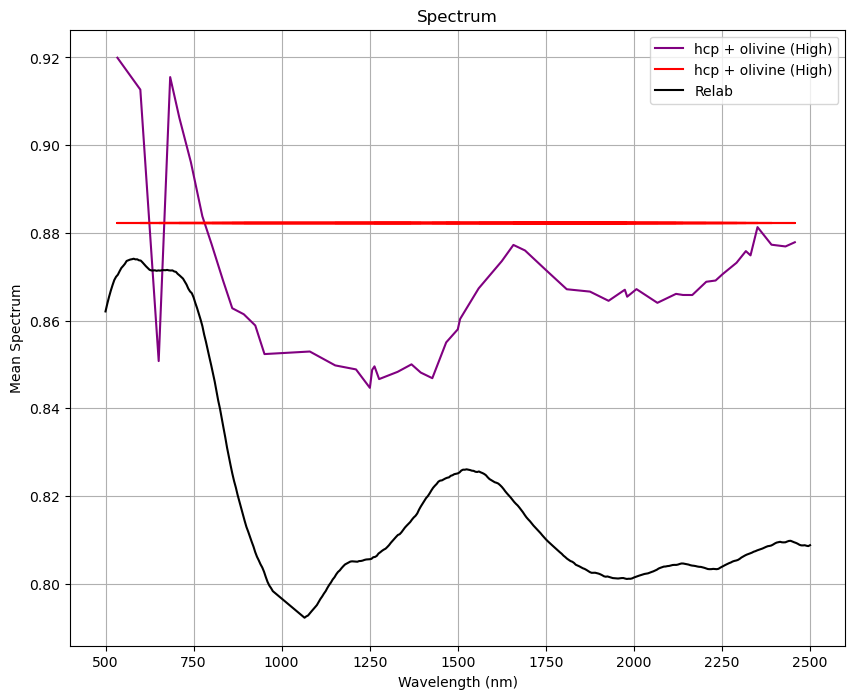

In [ ]:
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to extract and parse data from a single .gpkg file
def extract_and_parse_data(gpkg_file):
    df = gpd.read_file(gpkg_file)
    
    # Extract wavelength information and mean spectrum
    wavelength = np.array(df['wvl'].apply(parse_wvl).tolist())
    sl = len(wavelength[0])
    mean_spectrum = np.array(df['Spectrum Mean'].apply(parse_spectrum).tolist())
    ratio_spectrum = np.array(df['Ratio Spectrum'].apply(lambda x: parse_ratio_spectrum(x, sl)).tolist())
    
    # Extract parameter vector and parameter values vector
    parameter_vector = np.array(df['params'].apply(parse_parameter).tolist())
    parameter_values = np.array(df['Parameters Mean'].apply(parse_parameter_values).tolist())
    polygon_numbers = np.array(df['Polygon Number'].tolist())
    colors = np.array(df['Color'].tolist())
    categories = np.array(df['Category'].tolist())
    
    return wavelength, mean_spectrum, ratio_spectrum, parameter_vector, parameter_values, polygon_numbers, colors, categories

# Function to parse and clean a wavelength string
def parse_wvl(wvl_str):
    wvl_str = wvl_str.replace('[', '').replace(']', '').replace('\n', '')
    wvl_values = wvl_str.split()
    wvl_values = np.array([float(val) for val in wvl_values])
    return wvl_values

# Function to parse and clean a spectrum string
def parse_spectrum(spectrum_str):
    spectrum_str = spectrum_str.replace('[', '').replace(']', '').replace('\n', '')
    spectrum_values = spectrum_str.split()
    spectrum_values = np.array([float(val) for val in spectrum_values])
    return spectrum_values

# Function to parse and clean a ratio spectrum string
def parse_ratio_spectrum(spectrum_str, sl):
    spectrum_str = spectrum_str.replace('[', '').replace(']', '').replace(',', '').replace('\n', '')
    spectrum_values = spectrum_str.split()
    spectrum_values = np.array([float(val) if val is not None and val != 'None' else np.nan for val in spectrum_values])
    if len(spectrum_values) < 2:
        spectrum_values = list([np.nan])*sl
    return spectrum_values

# Function to parse and clean a parameter vector string (categorical data)
def parse_parameter(param_str):
    param_str = param_str.replace('[', '').replace(']', '').replace('\n', '')
    parameter_values = param_str.split()
    return parameter_values

# Function to parse and clean a parameter values vector string
def parse_parameter_values(param_str):
    param_str = param_str.replace('[', '').replace(']', '').replace('\n', '')
    parameter_values = param_str.split()
    parameter_values = np.array([float(val) for val in parameter_values])
    return parameter_values

# Dictionary to store all data
all_data = {
    'wavelength': [],
    'spectrum': [],
    'ratio_spectrum': [],
    'params': [],
    'parameter_values': [],
    'polygon_numbers': []
}


# Folder containing .gpkg files
basin_dir = 'Argyre'
# basin_dir = 'Hellas'
# cat_dir = 'categorized_2'
cat_dir = 'categorized_olivine_2'
# cat_dir = 'categorized'
folder_path = f'/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/shape_files/{basin_dir}/{cat_dir}'
# folder_path = f'/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/shape_files/{basin_dir}/ratio_files'
filename = 'T0433.gpkg'
poly_num = 283

gpkg_file = os.path.join(folder_path, filename)
wavelength, mean_spectrum, ratio_spectrum, parameter_vector, parameter_values, polygon_numbers, colors, categories = extract_and_parse_data(gpkg_file)

all_data['wavelength'].extend(wavelength)
all_data['spectrum'].extend(mean_spectrum)
all_data['ratio_spectrum'].extend(ratio_spectrum)
all_data['params'].extend(parameter_vector)
all_data['parameter_values'].extend(parameter_values)
all_data['parameter_values'].extend(polygon_numbers)

wvl = all_data['wavelength'][poly_num]
mask = (wvl >= 500) & (wvl <= 2500) & ((wvl < 980) | (wvl > 1060))
wvl = wvl[mask]
spec = all_data['ratio_spectrum'][poly_num]
spec = spec[mask]

# relab spectrum
import pandas as pd

filename = 'sa2ls8' #'c1jg15' #'c1mx91c2' #'c1mx84c2'
data_path = f'/Users/phillipsm/Documents/Research/MassifMapping/relab_plag_spinel_files/{filename}.csv'
relab_df = pd.read_csv(data_path)
relab_df_x = relab_df['wavelength']
relab_mask = (relab_df_x >= 500) & (relab_df_x <= 2500) & ((relab_df_x < 980) | (relab_df_x > 1060))
relab_df_x = relab_df_x[relab_mask]
relab_df_y = relab_df['reflectance'][relab_mask] + 0.55


plt.figure(figsize=(10, 8))
plt.plot(wvl, spec, color = colors[poly_num], label = categories[poly_num])
# plt.plot(wvl, spec, color = 'darkorange', label = categories[poly_num])
# make the background color black
# plt.gca().set_facecolor('black')
plt.plot(relab_df_x, relab_df_y, color = 'black', label = 'Relab')
plt.title('Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Mean Spectrum')
plt.legend()
plt.grid(True)
plt.show()


# Retrieve information from a point

In [44]:
import numpy as np
import geopandas as gpd
import pandas as pd
import os
from pyproj import Transformer, CRS

# Function to extract and parse data from a single .gpkg file
def extract_and_parse_data(gpkg_file, poly_num):

    df = gpd.read_file(gpkg_file)

    # Define the geographic CRS for Mars
    mars_geo_crs = CRS.from_proj4(
        '+proj=longlat +a=3396190 +b=3396190 +no_defs'
    )

    df_crs = df.crs

    # Define the transformer to convert from the projected CRS to the geographic CRS
    transformer = Transformer.from_crs(df_crs, mars_geo_crs, always_xy=True)
    
    for row in df.iterrows():
        if int(row[1]['Polygon Number']) == poly_num:
    
            polygon_number = np.array(row[1]['Polygon Number'])
            category = np.array(row[1]['Category'])
            # calculate representative point from geometry
            point = row[1]['geometry'].representative_point()
            lon, lat = transformer.transform(point.x, point.y)
    
    return polygon_number, category, lon, lat


# Folder containing .gpkg files
folder_path = '/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/shape_files/Argyre/categorized_2'
filenames = ['T0435.gpkg', 'T0435.gpkg', 'T0435.gpkg', 'T0435.gpkg', 'T0363.gpkg']
poly_nums = [0, 256, 250, 258, 48]
results_df = pd.DataFrame(columns=['CRISM Tile', 'polygon_num', 'category', 'lon', 'lat'])

for filename, poly_num in zip(filenames,poly_nums):
    gpkg_file = os.path.join(folder_path, filename)
    polygon_number, category, lon, lat = extract_and_parse_data(gpkg_file, poly_num)
    tile_num = filename.split('.')[0]
    results_df = pd.concat([results_df, pd.DataFrame({'CRISM Tile': [tile_num], 'polygon_num': [polygon_number], 'category': [category], 'lon': [lon], 'lat': [lat]})], ignore_index=True)

# save results to excel
results_df.to_excel('/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/Argyre_TES_locations.xlsx', index=False)


/var/folders/fz/2g6_hdjd4yndg54gmwq1402c0000gn/T/ipykernel_50072/66902183.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'CRISM Tile': [tile_num], 'polygon_num': [polygon_number], 'category': [category], 'lon': [lon], 'lat': [lat]})], ignore_index=True)
